# Introduction to Digital agro 

## Sensitivity Analysis of crop models

____

### Mikhail Gasanov

E-mail: Mikhail.Gasanov[a]skoltech.ru

tg:@misha_grol


## Clone utils and files from GitHub

In [2]:
# !git clone https://github.com/EDSEL-skoltech/Intro_to_Digital_Agriculture.git
# %cd ./Intro_to_Digital_Agriculture/Crop_models 
# !pip install SALib
# !pip install git+https://github.com/mishagrol/pcse

In [54]:
%matplotlib inline
import sys, os
import pcse
import pandas as pd
import numpy as np
import matplotlib
import yaml
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from pcse.models import Wofost71_PP
from pcse.base import ParameterProvider
from pcse.db import NASAPowerWeatherDataProvider
from pcse.fileinput import YAMLCropDataProvider
from pcse.util import WOFOST71SiteDataProvider, DummySoilDataProvider


print("This notebook was built with:")
print("python version: %s " % sys.version)
print("PCSE version: %s" %  pcse.__version__)

This notebook was built with:
python version: 3.6.11 | packaged by conda-forge | (default, Aug  5 2020, 20:19:23) 
[GCC Clang 10.0.1 ] 
PCSE version: 5.4.2


In [14]:
import warnings
warnings.filterwarnings("ignore")

# Sensitivity analysis of models
___



<img src="http://drive.google.com/uc?export=view&id=1uijz-Bm9Mxwv8eI6CL8QsumiP7ISqnFo">
<!-- <img src="http://drive.google.com/uc?export=view&id=1dPvni3r4B3FqMFKugxtT8GfH1_W1jNNR"> -->


## WOFOST parameters

In [15]:
df = pd.read_excel("./data/ScalarParametersOfWofost-Potential.xlsx")
display(df)

,Name,Typical Value,Category,Description,Unit
0,CFET,1.000,Water use,correction factor for evapotranspiration,-
1,CVL,0.720,Conversion of assimilates into biomass,efficiency conversion of assimilates into leaf...,kg / kg
2,CVO,0.820,Conversion of assimilates into biomass,efficiency conversion of assimilates into stor...,kg / kg
3,CVR,0.720,Conversion of assimilates into biomass,efficiency conversion of assimilates into root...,kg / kg
4,CVS,0.690,Conversion of assimilates into biomass,efficiency conversion of assimilates into stem...,kg / kg
5,DLC,16.000,Phenology,critical day length for development (lower thr...,hours
6,DLO,8.000,Phenology,optimum day length for development,hours
7,PERDL,0.030,Death rates,max. relative death rate of leaves due to wate...,-
8,Q10,2.000,Maintenance respiration,increase of the respiration rate per 10 °C tem...,-
9,RDI,10.000,Water use,initial rooting depth,cm


## Sobol’ Sequences versus Random numbers and regular grid


<img src="http://drive.google.com/uc?export=view&id=1ezjA8aa50P08EUybwdDyo8JKCP7lU7zw">

In [16]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami


__Docs [SALib](https://salib.readthedocs.io/en/latest/#)__

In this example, we will perform a Sobol’ sensitivity analysis of the _Ishigami_ function, shown below. The _Ishigami_ function is commonly used to test uncertainty and sensitivity analysis methods because it exhibits strong nonlinearity and nonmonotonicity.

$f(x)=\sin \left(x_{1}\right)+ \text{a}\, \operatorname{sin}^{2}\left(x_{2}\right)+ \text{b}\,  x_{3}^{4} \sin \left(x_{1}\right)$

In [32]:
problem = {
  'num_vars': 3,
  'names': ['x1', 'x2', 'x3'],
  'bounds': [[-np.pi, np.pi]]*3
}

In [36]:
# Generate samples
param_values = saltelli.sample(problem, 10, calc_second_order=True)
param_values.shape

(8000, 3)

Here, `param_values` is a NumPy matrix. If we run `param_values.shape`, we see that the matrix is **8000 by 3**. The Saltelli sampler generated 8000 samples. The Saltelli sampler generates $N∗(2D+2)$ samples, where in this example $N$ is 1000 (the argument we supplied) and $D$ is 3 (the number of model inputs). The keyword argument `calc_second_order=False` will exclude second-order indices, resulting in a smaller sample matrix with $N∗(D+2)$ rows instead.


In [37]:
# Run model (example)
Y = Ishigami.evaluate(param_values)

# Perform analysis
Si = sobol.analyze(problem, Y, print_to_console=True)
# Returns a dictionary with keys 'S1', 'S1_conf', 'ST', and 'ST_conf'
# (first and total-order indices with bootstrap confidence intervals)
T_Si, first_Si, (idx, second_Si) = sobol.Si_to_pandas_dict(Si)

Parameter S1 S1_conf ST ST_conf
x1 0.307975 0.060295 0.560137 0.096384
x2 0.447767 0.050511 0.438722 0.039817
x3 -0.004255 0.057172 0.242845 0.024133

Parameter_1 Parameter_2 S2 S2_conf
x1 x2 0.012205 0.086730
x1 x3 0.251526 0.085752
x2 x3 -0.009954 0.065483


In [38]:
Si_dict = dict(Si) 
sensitivity_indices = ['S1', 'ST', 'S1_conf', 'ST_conf']
Si_df = pd.DataFrame()
for SI in sensitivity_indices:
    Si_df = Si_df.append(pd.Series(Si_dict[SI]), ignore_index=True)

Si_df = Si_df.T
Si_df.columns = sensitivity_indices
Si_df

,S1,ST,S1_conf,ST_conf
0,0.307975,0.560137,0.060295,0.096384
1,0.447767,0.438722,0.050511,0.039817
2,-0.004255,0.242845,0.057172,0.024133


Consider the model output as
\begin{eqnarray*}
Y=f(X)=f\left(X_{1}, \ldots, X_{p}\right),
\end{eqnarray*}
where $f$ in our case part of agro-model simulator, $X$ are $p$ varied input parameters and $Y$ is the predicted output. Following the techniques by Sobol we represent the multi-variate random function $f$ using Hoeffding decomposition:
\begin{equation}
f(X_1,\dots,X_p) = f_0 + \sum_i^p f_i + \sum_i^p\sum_{j>i}^p f_{ij} + \dots + f_{1\dots p},
\end{equation}
where $f_0$ is a constant term, $f_i = f_i(X_i)$ denotes main effects, $f_{ij} = f_{ij}(X_i, X_j)$ and others describe higher-order interactions. These terms can be written as
\begin{equation*}
\begin{split}
f_0 &= E(Y),\\
f_i &= E_{X_{\sim i}}(Y | X_i) - E(Y),\\
f_{ij} &= E_{X_{\sim ij}}(Y | X_i, X_j) - f_i - f_j - f_0,\\
\dots
\end{split}
\end{equation*}
where $E$ is mathematical expectation and $X_{\sim i}$ denotes all parameters except $i^\text{th}$. Under the assumption that the input parameters are independent, total variance $V(Y)$ of the crop yield can be decomposed as follows:
\begin{equation*}
V(Y) = \sum_i^p V_i + \sum_i^p\sum_{j>i}^p V_{ij} + \dots + V_{12\dots p},
\end{equation*}
where partial variances are
\begin{equation*}
\begin{split}
V_i &= V[f_i(X_i)] = V_{X_i}\left[E_{X_{\sim i}}(Y | X_i)\right],\\
V_{ij} &= V[f_{ij}(X_i,X_j)] = V_{X_iX_j}\left[E_{X_{\sim ij}}(Y | X_i, X_j)\right] - V_i - V_j,\\
\dots
\end{split}
\end{equation*}

## Sobol index (first order, second order, total index)

This way, sensitivity indices (SI) can be introduced as 
\begin{equation}
\Large
S_i = \frac{V_i}{V(Y)},~S_{ij} = \frac{V_{ij}}{V(Y)},~\dots
\end{equation}
In order to incorporate all of the interactions for a particular parameter, one can compute the total effect index:
\begin{equation}
S_{T_i} = \frac{E_{X_{\sim i}}\left[V_{X_i}(Y|X_{\sim i})\right]}{V(Y)} = 1 - \frac{V_{X_{\sim i}}\left[E_{X_i}(Y | X_{\sim i})\right]}{V(Y)}
\end{equation}


From this assumption we can conclude:
\begin{equation}
\Large
0 \leq S_i \leq S_{T_i} \leq 1
\end{equation}

More -
* [Wiki](https://en.wikipedia.org/wiki/Sobol_sequence)
* [Habr](https://habr.com/ru/post/440892/)
* Feature selection [Skoltech ML 2020](https://github.com/adasegroup/ML2020_lectures/blob/master/lecture9/Lecture_9_Model_Feature_Selection_Sensitivity.pdf)

# Sensitivity analysis of WOFOST model 

<img src="http://drive.google.com/uc?export=view&id=1OPZ0xIFpc8Ku3wtt6XffKy2QKLashDWP">

## Model input info

In [50]:
# Define location, crop and season
latitude = 52.0
longitude = 5.0
crop_name = 'sugarbeet'
variety_name = 'Sugarbeet_601'
campaign_start_date = '2006-01-01'
emergence_date = "2006-03-31"
harvest_date = "2006-10-20"
max_duration = 300

In [51]:
# Here we define the agromanagement for sugar beet
agro_yaml = """
- {start}:
    CropCalendar:
        crop_name: {cname}
        variety_name: {vname}
        crop_start_date: {startdate}
        crop_start_type: emergence
        crop_end_date: {enddate}
        crop_end_type: harvest
        max_duration: {maxdur}
    TimedEvents: null
    StateEvents: null
""".format(cname=crop_name, vname=variety_name, 
           start=campaign_start_date, startdate=emergence_date, 
           enddate=harvest_date, maxdur=max_duration)
agro = yaml.safe_load(agro_yaml)
print(agro_yaml)


- 2006-01-01:
    CropCalendar:
        crop_name: sugarbeet
        variety_name: Sugarbeet_601
        crop_start_date: 2006-03-31
        crop_start_type: emergence
        crop_end_date: 2006-10-20
        crop_end_type: harvest
        max_duration: 300
    TimedEvents: null
    StateEvents: null



In [97]:
# Weather data for Netherlands
wdp = NASAPowerWeatherDataProvider(latitude=latitude, longitude=longitude)

from pcse.fileinput import csvweatherdataprovider
# Download the weather from CSV file if NASA POWER server doesn't response
# wdp = csvweatherdataprovider.CSVWeatherDataProvider('data/meteo/NASA_weather_latitude_52.0_longitude_5.0.csv')

# Parameter sets for crop, soil and site
# Standard crop parameter library
cropd = YAMLCropDataProvider()
# We don't need soil for potential production, so we use dummy values
soild = DummySoilDataProvider()
# Some site parameters
sited = WOFOST71SiteDataProvider(WAV=50, CO2=360.)

# Retrieve all parameters in the form of a single object. 
# In order to see all parameters for the selected crop already, we
# synchronise data provider cropd with the crop/variety: 
firstkey = list(agro[0])[0]
cropcalendar = agro[0][firstkey]['CropCalendar'] 
cropd.set_active_crop(cropcalendar['crop_name'], cropcalendar['variety_name'])
params = ParameterProvider(cropdata=cropd, sitedata=sited, soildata=soild)

In [75]:
# Define the target variable
target_variable = "TWSO"

# For each scalar parameter, determine a sensible interval 

Crop_parameters = ['TSUM1','TSUM2','SPAN','Q10','TDWI']
Model_parameters = {
    'num_vars':5,
    'names': Crop_parameters,
    'bounds':[[500, 800],
            [1200, 1600],
            [28, 37],
            [1.8, 2.2],
            [0.4, 0.6]]}

## Generate input parameters

In [93]:
param_values = saltelli.sample(Model_parameters, 10)

$n = N \times (D \times 2 +2)$

In [94]:
param_values.shape

(120, 5)

In [102]:
nsets = len(param_values)


# Loop over the samples of the parameter values and run WOFOST for each of the samples
target_results = []
pbar=tqdm()
pbar.reset(total=nsets)
for i, parameter in enumerate(param_values):
    pbar.update()
    params.clear_override()
    for name, value in zip(Model_parameters["names"], parameter):
        params.set_override(name, value)
    wofost = Wofost71_PP(params, wdp, agro)
    wofost.run_till_terminate()
    r = wofost.get_summary_output()
    target_result = r[0][target_variable]
#     print('Parameter:', parameter, 'Yield:', target_result)
    if target_result is None:
        print("Target variable is not available in summary output!")
        break
    target_results.append(target_result)

pbar.refresh()
target_results = np.array(target_results)

In [73]:

Si = sobol.analyze(Model_parameters, target_results, print_to_console=False)

In [83]:
Si_dict = dict(Si) 
sensitivity_indices = ['S1', 'ST', 'S1_conf', 'ST_conf']
Si_df = pd.DataFrame()
for SI in sensitivity_indices:
    Si_df = Si_df.append(pd.Series(Si_dict[SI]), ignore_index=True)

Si_df = Si_df.T
Si_df.columns = sensitivity_indices
Si_df['Parameters']=Crop_parameters
Si_df.set_index('Parameters', inplace=True)
Si_df

,S1,ST,S1_conf,ST_conf
Parameters,,,,
TSUM1,0.913165,1.042718,0.518546,0.806036
TSUM2,-0.048769,0.013741,0.077270,0.018143
SPAN,0.310392,0.312428,0.254017,0.251188
Q10,0.069177,0.024272,0.133090,0.016854
TDWI,0.036392,0.001314,0.031586,0.001273


Is it ok?


\begin{equation}
\Large
0 \leq S_i \leq S_{T_i} \leq 1
\end{equation}

# Visualization for sensitivity analysis

Plots by [Water programming group](https://waterprogramming.wordpress.com/2019/08/27/a-python-implementation-of-grouped-radial-convergence-plots-to-visualize-sobol-sensitivity-analysis-results/)

How to repeat: [Repo of SampleVIS](https://github.com/charlesrouge/SampleVis)

In [46]:
import numpy as np
from SALib.analyze import sobol
from SALib.sample import saltelli
from src.fishery import fish_game
import matplotlib.pyplot as plt
import itertools
import math

### Why number of samples is important?

n= 50
n= 100
n= 150
n= 200
n= 250
n= 300
n= 350
n= 400
n= 450


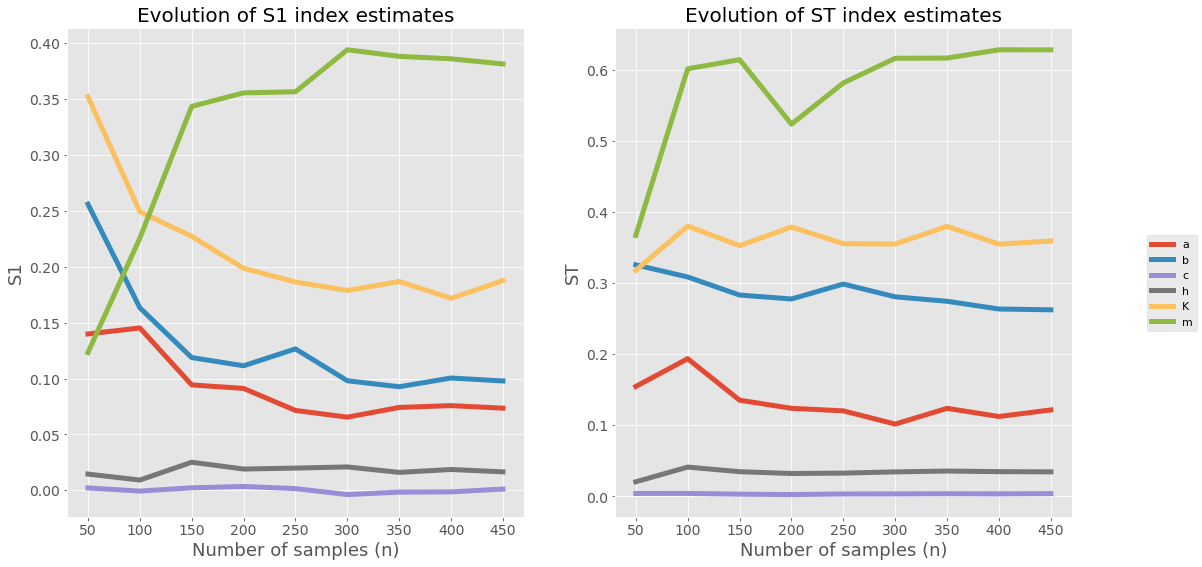

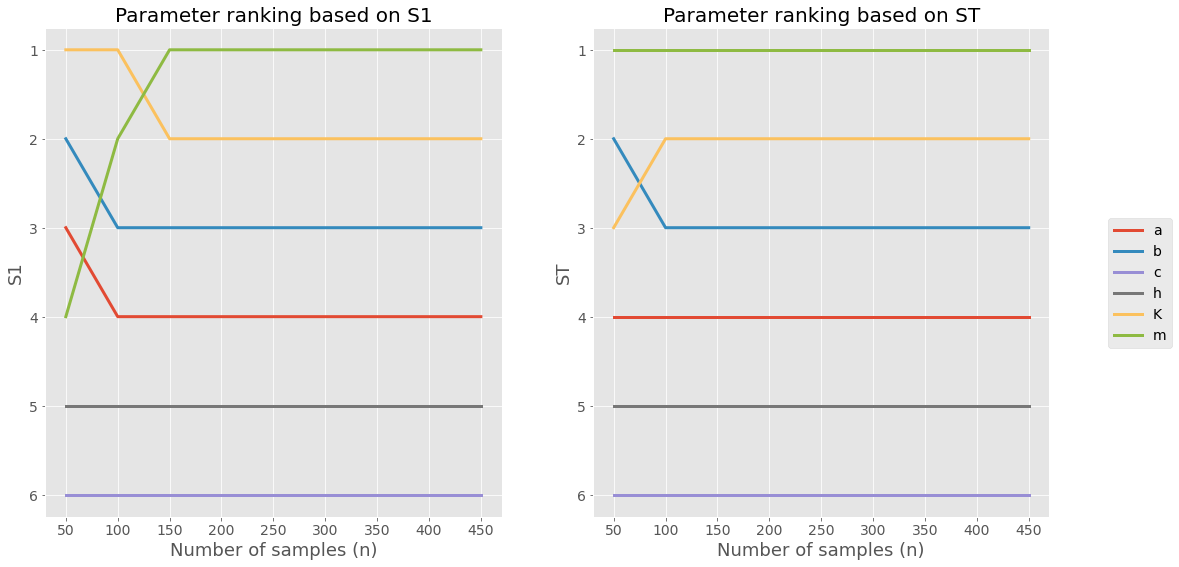

In [47]:
# Set up dictionary with system parameters
problem = {
  'num_vars': 6,
  'names': ['a', 'b', 'c','h',
            'K','m'],
  'bounds': [[ 0.002, 2],
             [0.005, 1],
             [0.2, 1],
             [0.001, 1],
             [100, 5000],
             [0.1, 1.5]]
}

# Array with n's to use
nsamples = np.arange(50, 500, 50)

# Arrays to store the index estimates
S1_estimates = np.zeros([problem['num_vars'],len(nsamples)])
ST_estimates = np.zeros([problem['num_vars'],len(nsamples)])

# Loop through all n values, create sample, evaluate model and estimate S1 & ST
for i in range(len(nsamples)):
    print('n= '+ str(nsamples[i]))
    # Generate samples
    sampleset = saltelli.sample(problem, nsamples[i],calc_second_order=False)
    # Run model for all samples
    output = [fish_game(*sampleset[j,:]) for j in range(len(sampleset))]
    # Perform analysis
    results = sobol.analyze(problem, np.asarray(output), calc_second_order=False,print_to_console=False)
    # Store estimates
    ST_estimates[:,i]=results['ST']
    S1_estimates[:,i]=results['S1']

np.save('ST_estimates.npy', ST_estimates)
np.save('S1_estimates.npy', S1_estimates)

S1_estimates = np.load('S1_estimates.npy')
ST_estimates = np.load('ST_estimates.npy')

# Generate figure showing evolution of indices
fig =  plt.figure(figsize=(18,9))
ax1 = fig.add_subplot(1,2,1)
handles = []
for j in range(problem['num_vars']):
    handles += ax1.plot(nsamples, S1_estimates[j,:], linewidth=5)
ax1.set_title('Evolution of S1 index estimates', fontsize=20)
ax1.set_ylabel('S1', fontsize=18)
ax1.set_xlabel('Number of samples (n)', fontsize=18)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax2 = fig.add_subplot(1,2,2)
for j in range(problem['num_vars']):
    ax2.plot(nsamples, ST_estimates[j,:], linewidth=5)
ax2.set_title('Evolution of ST index estimates', fontsize=20)
ax2.set_ylabel('ST', fontsize=18)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.set_xlabel('Number of samples (n)', fontsize=18)
fig.legend(handles, problem['names'], loc = 'right', fontsize=11)
plt.show()
#plt.savefig('indexevolution.png')

# Calculate parameter rankings
S1_ranks = np.zeros_like(S1_estimates)
ST_ranks = np.zeros_like(ST_estimates)
for i in range(len(nsamples)):
    orderS1 = np.argsort(S1_estimates[:,i])
    orderST = np.argsort(ST_estimates[:,i])
    S1_ranks[:,i] = orderS1.argsort()
    ST_ranks[:,i] = orderST.argsort()
    
# Generate figure showing evolution of ranks
fig =  plt.figure(figsize=(18,9))
ax1 = fig.add_subplot(1,2,1)
handles = []
for j in range(problem['num_vars']):
    handles += ax1.plot(nsamples, S1_ranks[j,:], linewidth=3)
ax1.set_title('Parameter ranking based on S1', fontsize=20)
ax1.set_ylabel('S1', fontsize=18)
ax1.set_xlabel('Number of samples (n)', fontsize=18)
ax1.set_yticklabels(np.arange(problem['num_vars']+1, 0, -1))
ax1.tick_params(axis='both', which='major', labelsize=14)
ax2 = fig.add_subplot(1,2,2)
for j in range(problem['num_vars']):
    ax2.plot(nsamples, ST_ranks[j,:], linewidth=3)
ax2.set_title('Parameter ranking based on ST', fontsize=20)
ax2.set_ylabel('ST', fontsize=18)
ax2.set_yticklabels(np.arange(problem['num_vars']+1, 0, -1))
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.set_xlabel('Number of samples (n)', fontsize=18)
fig.legend(handles, problem['names'], loc = 'right', fontsize=14)
#plt.show()
#plt.savefig('rankingevolution.png')

## Radial plot for SA

In [84]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import math
from numpy import genfromtxt
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
sns.set_style('whitegrid', {'axes_linewidth': 0, 'axes.edgecolor': 'white'})

## Plot function

In [85]:
def is_significant(value, confidence_interval, threshold="conf"):
    if threshold == "conf":
        return value - abs(confidence_interval) > 0
    else:
        return value - abs(float(threshold)) > 0
 
def grouped_radial(SAresults, parameters, radSc=2.0, scaling=1, widthSc=0.5, STthick=1, varNameMult=1.3, colors=None, groups=None, gpNameMult=1.5, threshold="conf"):
    # Derived from https://github.com/calvinwhealton/SensitivityAnalysisPlots
    fig, ax = plt.subplots(1, 1)
    color_map = {}
     
    # initialize parameters and colors
    if groups is None:
         
        if colors is None:
            colors = ["k"]
         
        for i, parameter in enumerate(parameters):
            color_map[parameter] = colors[i % len(colors)]
    else:        
        if colors is None:
            colors = sns.color_palette("deep", max(3, len(groups)))
         
        for i, key in enumerate(groups.keys()):
            #parameters.extend(groups[key])
             
            for parameter in groups[key]:
                color_map[parameter] = colors[i % len(colors)]
     
    n = len(parameters)
    angles = radSc*math.pi*np.arange(0, n)/n
    x = radSc*np.cos(angles)
    y = radSc*np.sin(angles)
     
    # plot second-order indices
    for i, j in itertools.combinations(range(n), 2):
        #key1 = parameters[i]
        #key2 = parameters[j]
         
        if is_significant(SAresults["S2"][i][j], SAresults["S2_conf"][i][j], threshold):
            angle = math.atan((y[j]-y[i])/(x[j]-x[i]))
                 
            if y[j]-y[i] < 0:
                angle += math.pi
                 
            line_hw = scaling*(max(0, SAresults["S2"][i][j])**widthSc)/2
                 
            coords = np.empty((4, 2))
            coords[0, 0] = x[i] - line_hw*math.sin(angle)
            coords[1, 0] = x[i] + line_hw*math.sin(angle)
            coords[2, 0] = x[j] + line_hw*math.sin(angle)
            coords[3, 0] = x[j] - line_hw*math.sin(angle)
            coords[0, 1] = y[i] + line_hw*math.cos(angle)
            coords[1, 1] = y[i] - line_hw*math.cos(angle)
            coords[2, 1] = y[j] - line_hw*math.cos(angle)
            coords[3, 1] = y[j] + line_hw*math.cos(angle)
 
            ax.add_artist(plt.Polygon(coords, color="0.75"))
         
    # plot total order indices
    for i, key in enumerate(parameters):
        if is_significant(SAresults["ST"][i], SAresults["ST_conf"][i], threshold):
            ax.add_artist(plt.Circle((x[i], y[i]), scaling*(SAresults["ST"][i]**widthSc)/2, color='w'))
            ax.add_artist(plt.Circle((x[i], y[i]), scaling*(SAresults["ST"][i]**widthSc)/2, lw=STthick, color='0.4', fill=False))
     
    # plot first-order indices
    for i, key in enumerate(parameters):
        if is_significant(SAresults["S1"][i], SAresults["S1_conf"][i], threshold):
            ax.add_artist(plt.Circle((x[i], y[i]), scaling*(SAresults["S1"][i]**widthSc)/2, color='0.4'))
            
    # add labels
    for i, key in enumerate(parameters):                
        ax.text(varNameMult*x[i], varNameMult*y[i], key, ha='center', va='center',
                rotation=angles[i]*360/(2*math.pi) - 90,
                color=color_map[key])
         
    if groups is not None:
        for i, group in enumerate(groups.keys()):
            print(group)
            group_angle = np.mean([angles[j] for j in range(n) if parameters[j] in groups[group]])
             
            ax.text(gpNameMult*radSc*math.cos(group_angle), gpNameMult*radSc*math.sin(group_angle), group, ha='center', va='center',
                rotation=group_angle*360/(2*math.pi) - 90,
                color=colors[i % len(colors)])
             
    ax.set_facecolor('white')
    ax.set_xticks([])
    ax.set_yticks([])
#     ax.
    plt.axis('equal')
    plt.axis([-2*radSc, 2*radSc, -2*radSc, 2*radSc])
    #plt.show()
 
     
    return fig

## Range of soil parameters

In [86]:
problem = {
    'num_vars':6,
    'names':['SOC', 'Sand', 'Clay', 'pH', 'CN', 'BD'],
    'bounds':[[2.58, 6.20],
              [0.01, 0.30],
              [0.01, 0.30],
              [4.6, 6.9],
              [10.9, 12.4],
              [900, 1350]]
}

In [87]:
#names for csv files
list_of_csv=['soybean-000-2015.csv', 'sugar-beet-2011.csv', 'sugar-beet-2017.csv',
'spring-barley-2012.csv', 'sugar-beet-2014.csv']
list_of_names=['soybean-000-2015', 'sugar-beat-2011', 'sugar-beat-2017',
'spring-barley-2012', 'sugar-beat-2014']
list_of_totals=['total_SI_'+x for x in list_of_names]
list_of_first=['fisrt_SI_'+x for x in list_of_names]
list_of_second=['second_SI_'+x for x in list_of_names]
list_of_SI=['SI_'+x for x in list_of_names]

In [90]:
for j, i in enumerate(list_of_csv):
        all_data_csv = genfromtxt('./data/monica_sensitivity/'+str(i), delimiter=',')
        output = all_data_csv[:,2]
        print(i)
        list_of_SI[j] = sobol.analyze(problem, output, calc_second_order=True, conf_level=0.95, print_to_console=False)

soybean-000-2015.csv
sugar-beet-2011.csv
sugar-beet-2017.csv
spring-barley-2012.csv
sugar-beet-2014.csv


Soil physics
Soil chemistry


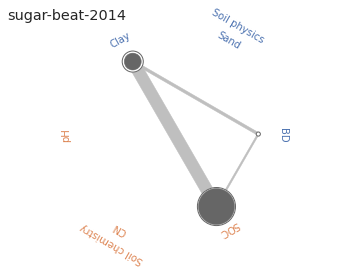

In [ ]:
groups={"Soil physics" : ["Sand", "Clay", "BD"],
        "Soil chemistry" : ["pH", "SOC", "CN"]}
 
fig = grouped_radial(list_of_SI[4], ['BD', 'Sand', 'Clay', 'pH', 'CN', 'SOC'], groups=groups, threshold=0.001)
red_patch = mpatches.Patch(color='red', label='The red data')
plt.title(list_of_names[4], loc='left')

plt.show()

# Homework
____



## Resources

__SA and UQ__


1) [Rhodium project](https://github.com/Project-Platypus/Rhodium.git)


2) [SALib](https://github.com/SALib/SALib)

__Model__

3) [PCSE](https://pcse.readthedocs.io/en/stable/index.html)

4) How to install PCSE at local machine
    `conda env create -f` [py3_pcse.yml](https://github.com/mishagrol/Seminar_Sobol/blob/master/py3_pcse.yml)

Аny questions  -  

Telegram - `@misha_grol`

In [105]:
from pcse.fileinput import YAMLCropDataProvider
cropd = YAMLCropDataProvider()
# cropd.print_crops_varieties()

## Part 1 – Crop Yield Prediction (PCSE/WOFOST)  

You can use the seminars’ notebook:  

* Assess the yield of one of the crops for the Moscow region over several years (potatoes, sugar beets)   
Crop  - [List of crops](https://github.com/ajwdewit/WOFOST_crop_parameters) \
Weather  - [NASAdataprovider in PCSE](https://pcse.readthedocs.io/en/stable/code.html?highlight=NASA#pcse.db.NASAPowerWeatherDataProvider)   
* Generate plots for biomass growth, crop yield and seasonal weather for one year


### Agromanagement for Moscow Potato crop and NPK fertilization
```
"name": "Potato", 
"latitude": 54.85, 
"longitude": 38.85, 
"crop_start": "2019-04-20", 
"crop_end": "2019-09-15", 
"crop_name": "potato", 
"npk_events": ["2019-06-22"], 
"npk": [[90,10,90]]
```

### Available crop

In [ ]:
from pcse.fileinput import YAMLCropDataProvider
cropd = YAMLCropDataProvider()
# cropd.print_crops_varieties()

## Part 2 – Sensitivity Analysis (SALib)  

1) Perform sensitivity analysis of one of the model blocks (crop, soil, agromanagement *) with SALib. You can choose one of the methods that you consider necessary (Sobol, FAST, ...). 

    Generate samples – In report provide the size of the resulting matrix and the sample size (N) 

    Conduct parameter sensitivity analysis  - In report provide S1 and ST indices.  

2) Generate plots (Hist, etc.)  

*3) Speed-up sensitivity analysis with multiprocessing 

*4) Estimate the required number of simulations to obtain reliable values of the sensitivity indices. Try to estimate the sample size at the confidence interval of the sensitivity indices. 

* Please note that working with discrete data can cause certain difficulties. 

### bonus

__Morris method__


Generate a sample using the Method of Morris

Three variants of Morris' sampling for elementary effects is supported:

- Vanilla Morris
- Optimised trajectories when ``optimal_trajectories=True`` (using
    Campolongo's enhancements from 2007 and optionally Ruano's enhancement
    from 2012; ``local_optimization=True``)
- Groups with optimised trajectories when ``optimal_trajectories=True`` and
    the problem definition specifies groups (note that ``local_optimization``
    must be ``False``)

At present, optimised trajectories is implemented using either a brute-force
approach, which can be very slow, especially if you require more than four
trajectories, or a local method based which is much faster. Both methods now
implement working with groups of factors.

Note that the number of factors makes little difference,
but the ratio between number of optimal trajectories and the sample size
results in an exponentially increasing number of scores that must be
computed to find the optimal combination of trajectories.  We suggest going
no higher than 4 from a pool of 100 samples with the brute force approach.
With local_optimization = True (which is default),
it is possible to go higher than the previously suggested 4 from 100.



Parameter                         Mu_Star         Mu    Mu_Star_Conf      Sigma
x1                                  2.564     -0.039           0.052      2.690
x2                                  1.431     -0.047           0.044      1.619
x3                                  0.603     -0.003           0.024      0.704
x4                                  0.330      0.004           0.013      0.388
x5                                  0.034     -0.000           0.001      0.040
x6                                  0.034      0.000           0.001      0.040
x7                                  0.033     -0.001           0.001      0.040
x8                                  0.034      0.003           0.001      0.039


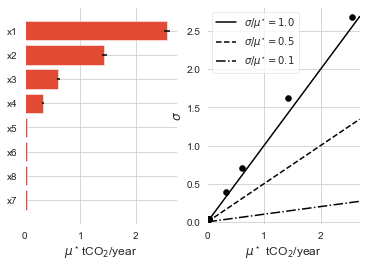

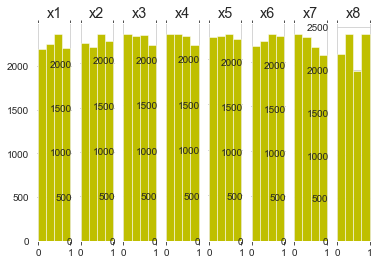

In [91]:
import sys

from SALib.analyze import morris
from SALib.sample.morris import sample
from SALib.test_functions import Sobol_G
from SALib.util import read_param_file
from SALib.plotting.morris import horizontal_bar_plot, covariance_plot, \
    sample_histograms
import matplotlib.pyplot as plt

#sys.path.append('../..')

# Read the parameter range file and generate samples
#problem = read_param_file('/Users/mikhailgasanov/Documents/GIT/SALib/src/SALib/test_functions/params/Sobol_G.txt')
# or define manually without a parameter file:
problem = {
 'num_vars': 8,
 'names': ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8'],
 'groups': None,
 'bounds': [[0.0, 1.0],
            [0.0, 1.0],
            [0.0, 1.0],
            [0.0, 1.0],
            [0.0, 1.0],
            [0.0, 1.0],
            [0.0, 1.0],
            [0.0, 1.0]]
}
# Files with a 4th column for "group name" will be detected automatically, e.g.
# param_file = '../../src/SALib/test_functions/params/Ishigami_groups.txt'

# Generate samples
param_values = sample(problem, N=1000, num_levels=4,
                      optimal_trajectories=None)

# To use optimized trajectories (brute force method),
# give an integer value for optimal_trajectories

# Run the "model" -- this will happen offline for external models
Y = Sobol_G.evaluate(param_values)

# Perform the sensitivity analysis using the model output
# Specify which column of the output file to analyze (zero-indexed)
Si = morris.analyze(problem, param_values, Y, conf_level=0.95,
                    print_to_console=True,
                    num_levels=4, num_resamples=100)
# Returns a dictionary with keys 'mu', 'mu_star', 'sigma', and 'mu_star_conf'
# e.g. Si['mu_star'] contains the mu* value for each parameter, in the
# same order as the parameter file

fig, (ax1, ax2) = plt.subplots(1, 2)
horizontal_bar_plot(ax1, Si, {}, sortby='mu_star', unit=r"tCO$_2$/year")
covariance_plot(ax2, Si, {}, unit=r"tCO$_2$/year")

fig2 = plt.figure()
sample_histograms(fig2, param_values, problem, {'color': 'y'})
plt.show()